In [1]:
# 1. Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 2. Load dataset
df = pd.read_csv("cleaned_hour_no_outliers.csv")

In [5]:
# 3. Preprocessing
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

UNIVARIATE ANALYSIS

Descriptive Statistics

In [9]:
#summary statistics for numerical columns
print(df.describe())

             season            yr          mnth            hr       holiday  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       2.501640      0.502561      6.537775     11.546752      0.028770   
std        1.106918      0.500008      3.438776      6.914405      0.167165   
min        1.000000      0.000000      1.000000      0.000000      0.000000   
25%        2.000000      0.000000      4.000000      6.000000      0.000000   
50%        3.000000      1.000000      7.000000     12.000000      0.000000   
75%        3.000000      1.000000     10.000000     18.000000      0.000000   
max        4.000000      1.000000     12.000000     23.000000      1.000000   

            weekday    workingday    weathersit          temp         atemp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       3.003683      0.682721      1.425283      0.496987      0.475775   
std        2.005771      0.465431      0.639357    

Histograms for Numerical Features

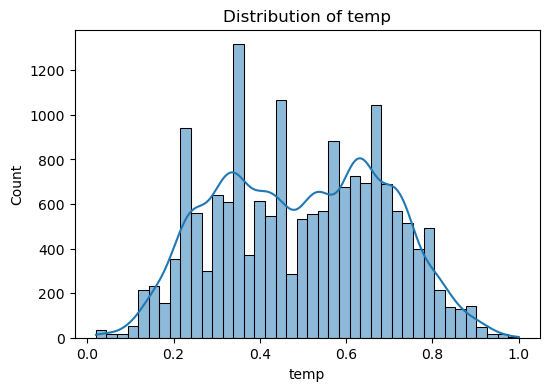

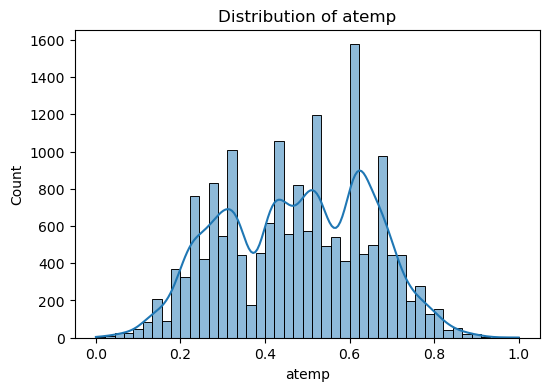

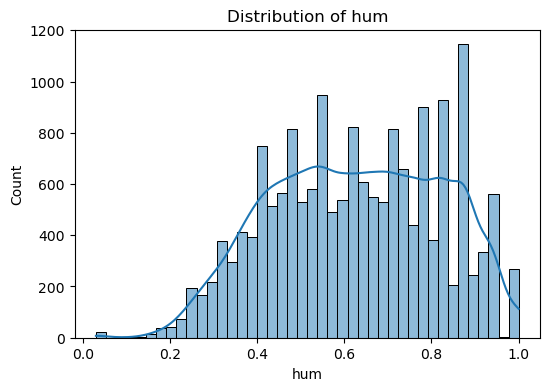

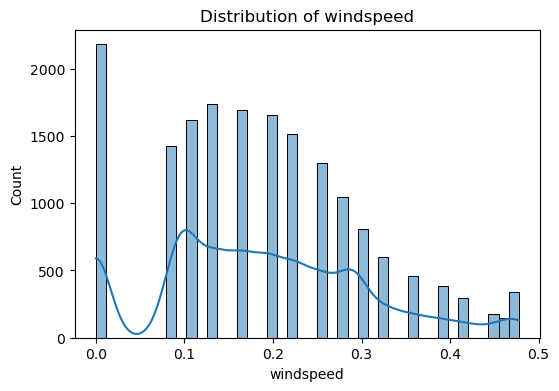

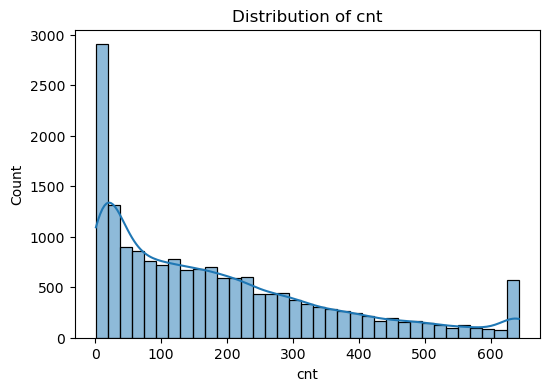

In [14]:
num_cols=['temp','atemp','hum','windspeed','cnt']

for col in  num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col],kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

Boxplots for comparing

In [16]:
# Load original data
dfor = pd.read_csv('hour.csv')
dfor.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)

# Create a copy to preserve the original
df_original = dfor.copy()

In [18]:
def remove_outliers_iqr(data, columns):
    dfor_clean = data.copy()
    for col in columns:
        Q1 = dfor_clean[col].quantile(0.25)
        Q3 = dfor_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        dfor_clean = dfor_clean[(dfor_clean[col] >= lower) & (dfor_clean[col] <= upper)]
    return dfor_clean

# Columns to check for outliers
num_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
dfor_clean = remove_outliers_iqr(dfor, num_cols)

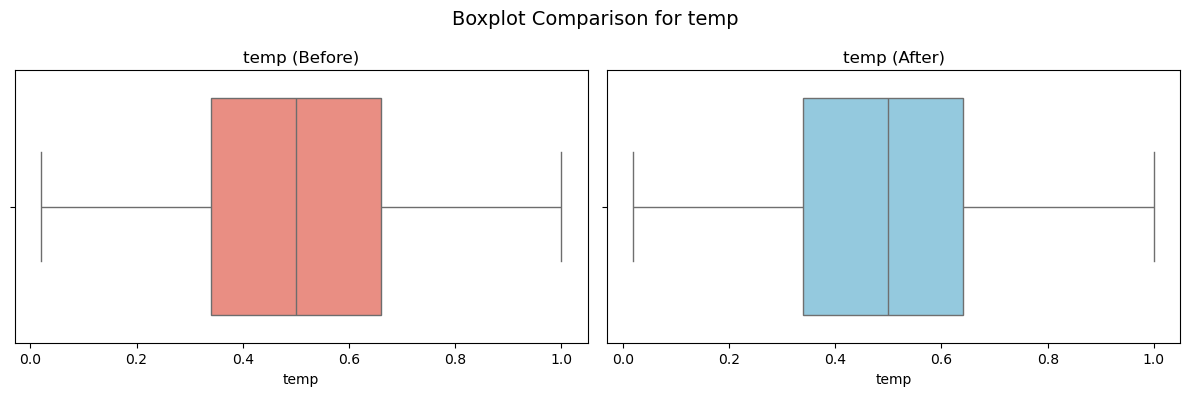

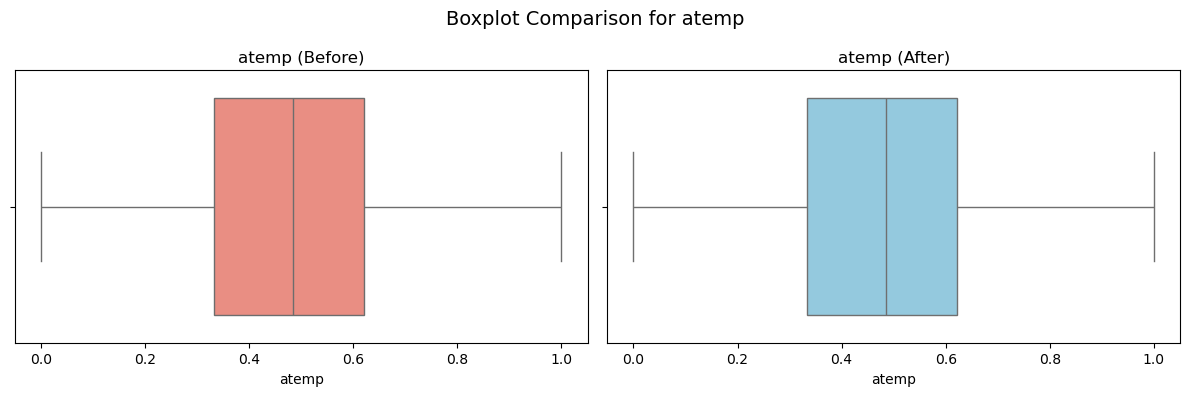

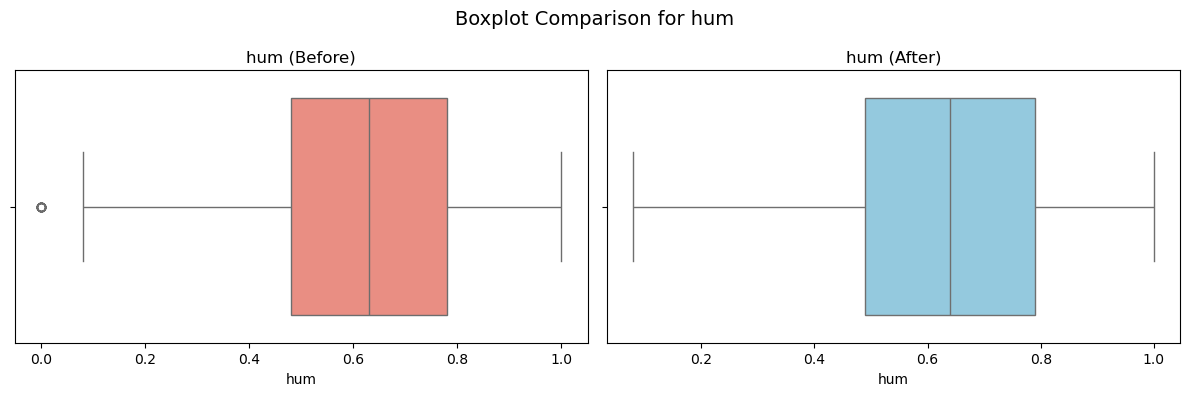

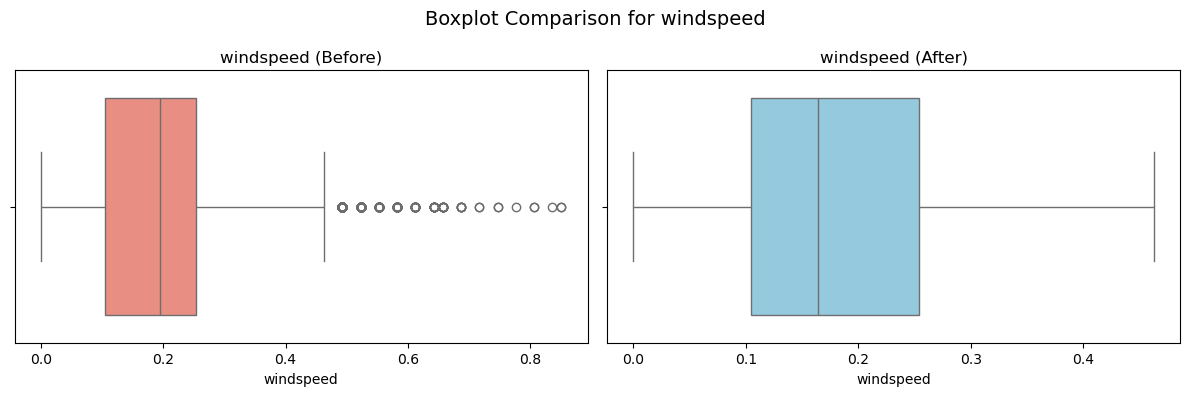

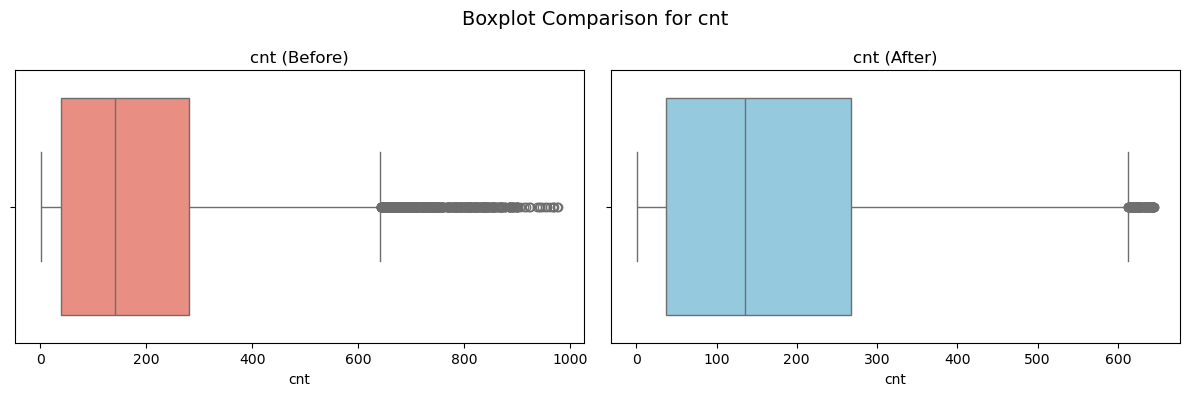

In [22]:
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.boxplot(x=df_original[col], ax=axes[0], color='salmon')
    axes[0].set_title(f'{col} (Before)')

    sns.boxplot(x=dfor_clean[col], ax=axes[1], color='skyblue')
    axes[1].set_title(f'{col} (After)')

    plt.suptitle(f'Boxplot Comparison for {col}', fontsize=14)
    plt.tight_layout()
    plt.show()

BIVARIATE ANALYSIS

Correlation Matrix(Numerical vs Target)

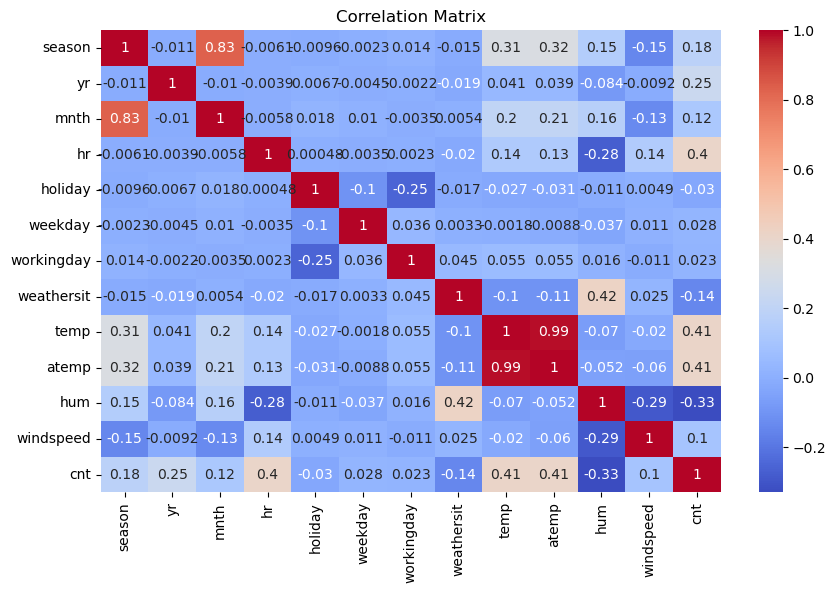

In [27]:
plt.figure(figsize=(10,6))
corr=df.corr()
sns.heatmap(corr,annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

INFERENCE:
1. temp: Positive correlation. Higher temperature increases rentals.
2. hr: Strong relationship. Bike rentals vary by hour of day(morning/evening peaks)
3. workingday,weekday,holiday: Very Weak relationship. Doesn't have much effect on bike rentals.
4. windspeed: Negative correlation.Higher windspeed reduces bike rentals.

Covariance Matrix

In [31]:
print(df.cov())

               season         yr       mnth          hr   holiday   weekday  \
season       1.225268  -0.005946   3.160817   -0.046817 -0.001774 -0.005185   
yr          -0.005946   0.250008  -0.018007   -0.013369  0.000559 -0.004498   
mnth         3.160817  -0.018007  11.825178   -0.137239  0.010595  0.071733   
hr          -0.046817  -0.013369  -0.137239   47.808998  0.000554 -0.048509   
holiday     -0.001774   0.000559   0.010595    0.000554  0.027944 -0.034230   
weekday     -0.005185  -0.004498   0.071733   -0.048509 -0.034230  4.023119   
workingday   0.007080  -0.000511  -0.005565    0.007354 -0.019643  0.033566   
weathersit  -0.010279  -0.006124   0.011871   -0.089311 -0.001821  0.004246   
temp         0.066506   0.003939   0.133551    0.183207 -0.000880 -0.000693   
atemp        0.060754   0.003370   0.122975    0.158927 -0.000890 -0.003041   
hum          0.032110  -0.008079   0.108943   -0.368821 -0.000343 -0.014341   
windspeed   -0.019215  -0.000542  -0.054371    0.112

INFERENCE:
1. cnt & temp: Positive covariance. As temperature increases, bike rentals increase.
2. cnt & hum: Negative covariance. Higher humidity is weakly associated with fewer rentals.
3. cnt & windspeed: Slighlty negative. Strong winds may slighlty reduce rentals.

ANNOVA: Categorical-Target(cnt)

In [40]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('cnt ~ C(weekday)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq       df         F    PR(>F)
C(weekday)  5.256465e+05      6.0  2.965705  0.006787
Residual    5.131737e+08  17372.0       NaN       NaN


REJECT NULL HYPOTHESIS: There is a statistically significant difference in average bike rentals across different weekdays.
This suggests that rentals are not uniform throughout the week- likely higher on weekdays vs weekends or vice-versa. 

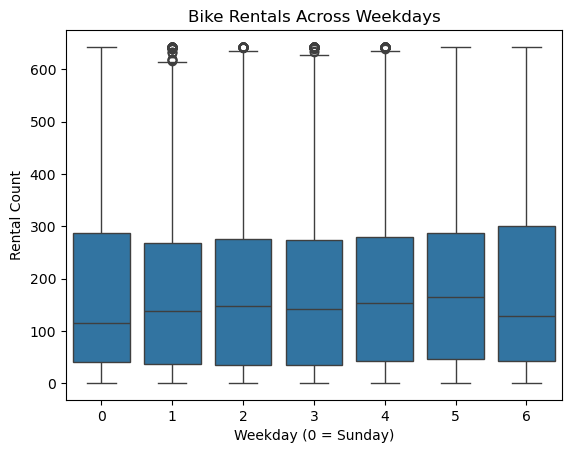

In [43]:
sns.boxplot(x='weekday', y='cnt', data=df)
plt.title("Bike Rentals Across Weekdays")
plt.xlabel("Weekday (0 = Sunday)")
plt.ylabel("Rental Count")
plt.show()

T-TEST: Holiday vs Non-Holiday

In [36]:
from scipy.stats import ttest_ind

holiday = df[df['holiday'] == 1]['cnt']
non_holiday = df[df['holiday'] == 0]['cnt']
t_stat, p_val = ttest_ind(holiday, non_holiday)
print(f"T-test result:\nT-statistic = {t_stat}, P-value = {p_val}")

T-test result:
T-statistic = -3.920724220705588, P-value = 8.862205723860499e-05


REJECT NULL-HYPOTHESIS: There is a stastically significant difference in bike rentals between holidays and Non-holidays.
Holiday Rentals are significantly lower than non-holiday rentals.

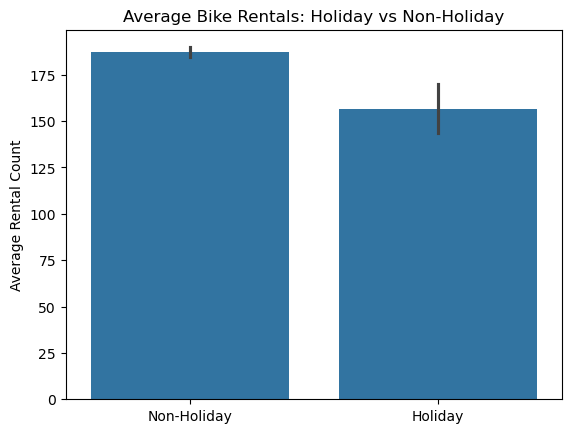

In [38]:
sns.barplot(x='holiday', y='cnt', data=df)
plt.xticks([0,1], ['Non-Holiday', 'Holiday'])
plt.title('Average Bike Rentals: Holiday vs Non-Holiday')
plt.ylabel('Average Rental Count')
plt.xlabel('')
plt.show()